In [5]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Affine Structure from Motion (50 points)

## Overview
<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/sfm_hw.jpg" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/sfm_algo.jpg" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [6]:
# # Download Data -- run this cell only one time per runtime
# !gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
# !unzip "/content/Part2_data.zip" -d "/content/"
# # Load Matches
data = loadmat('Part2_data/tracks.mat')

### Code

In [7]:
track_x = data['track_x']
track_y = data['track_y']

# Remove the nan value
# YOUR CODE HERE

def clean_tracks(track_x, track_y):
  cleaned_track_x = []
  cleaned_track_y = []
  for i in range(len(track_x)):
    if not (np.isnan(track_x[i]).any() or np.isnan(track_y[i]).any()):
      cleaned_track_x.append(np.hstack(track_x[i]).astype(float))
      cleaned_track_y.append(np.hstack(track_y[i]).astype(float))

  return np.array(cleaned_track_x, dtype=float), np.array(cleaned_track_y, dtype=float)

x, y = clean_tracks(track_x, track_y)

def affineSFM(x, y):
  '''
  Function: Affine structure from motion algorithm
  % Normalize x, y to zero mean
  % Create measurement matrix
  D = [xn' ; yn'];
  % Decompose and enforce rank 3
  % Apply orthographic constraints
  '''

  # Normalize x, y to zero mean
  mean_x = np.mean(x, axis= 0)
  mean_y = np.mean(y, axis= 0)
  x -= mean_x
  y -= mean_y
  x = x.T
  y = y.T

  #Create measurement matrix
  D = np.zeros((x.shape[0]*2, x.shape[1]))
  for i in range(x.shape[0]):
    D[2*i] = x[i,:]
    D[2*i+1] = y[i,:]


  # Factorize D
  U, W, Vt = np.linalg.svd(D)
  U3 = U[:, :3]
  W3 = np.diag(W[:3])
  V3t = Vt[:3, :]
  # Create motion and shape matrices
  
  A = U3 @ np.sqrt(W3)
  S = np.sqrt(W3) @ V3t

  # eliminate affine ambiguity
  F = []
  M = []
  for i in range(0, A.shape[0], 2):
    Ai1 = A[i,:]
    Ai2 = A[i+1,:]

    M1 = np.outer(Ai1, Ai1).flatten()
    M2 = np.outer(Ai2, Ai2).flatten()
    M3 = np.outer(Ai1, Ai2).flatten()

    M += [M1,M2,M3]
    F += [1,1,0]
    
  np.vstack(M)
  np.vstack(F)
  M = np.asarray(M)
  F = np.asarray([F]).T

  L = np.linalg.lstsq(M, F)[0]
  L = L.reshape((3,3))

  C = np.linalg.cholesky(L)
  A = A @ C
  S = np.linalg.inv(C) @ S

  return A , S

### Write-up


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


/var/folders/_t/jw3df6_x4xlcy5q85v7qnwqr0000gn/T/ipykernel_5918/1234318044.py:73: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  L = np.linalg.lstsq(M, F)[0]


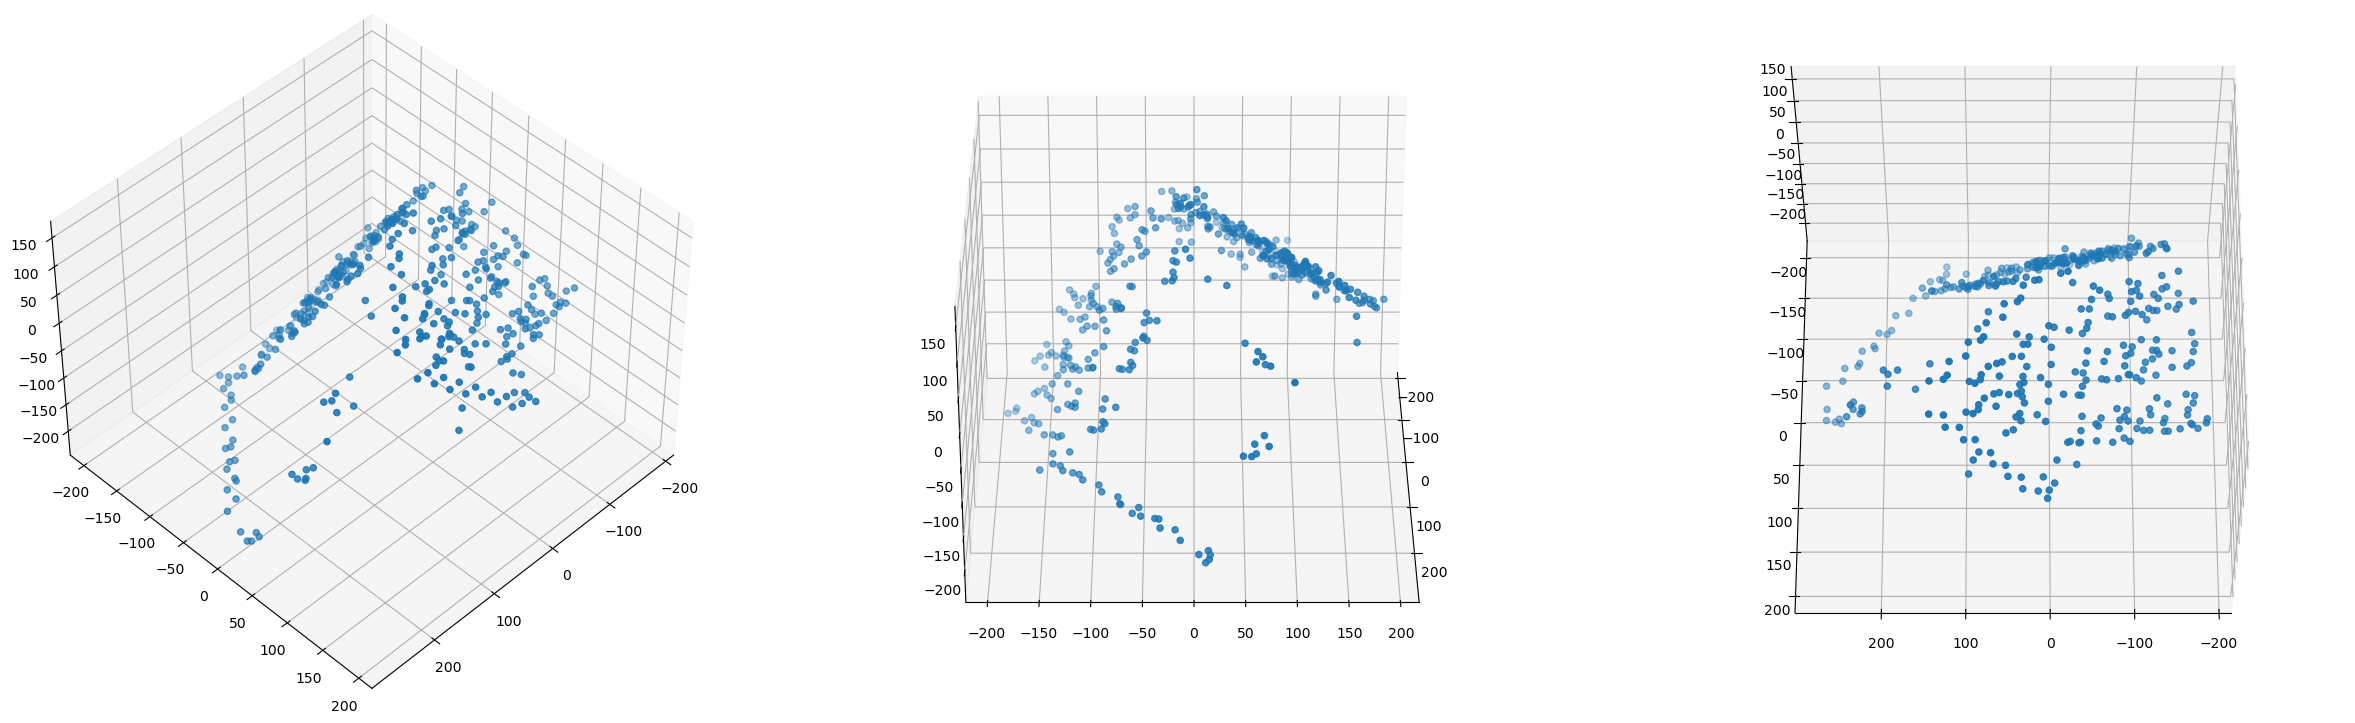

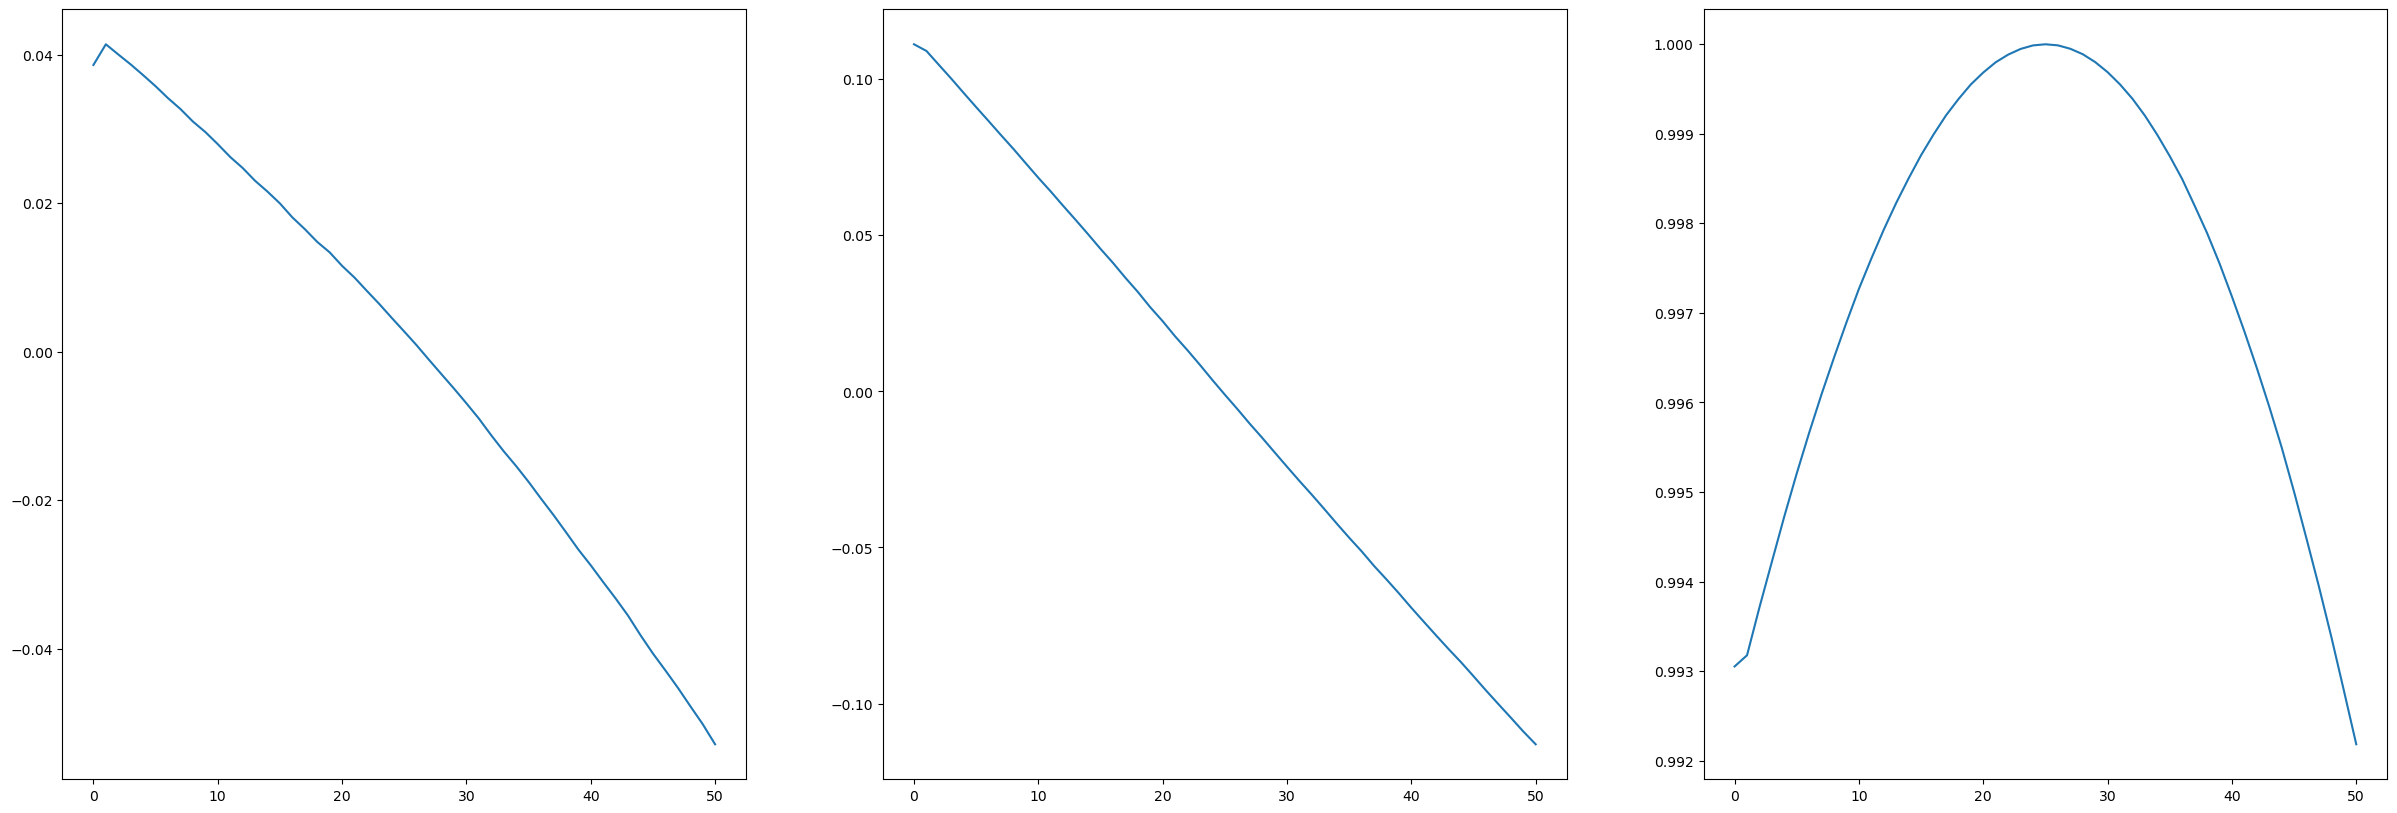

In [8]:
def plot_3d(S):
    fig = plt.figure(figsize=(30, 10))

    for i, angle in enumerate([(45, 45), (30, 0), (60, 90)]):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        ax.scatter(S[0, :], S[1, :], S[2, :])
        ax.view_init(angle[0], angle[1])
    plt.show()

def plot_camera(A):
    a_k = []
    for i in range(0,A.shape[0],2):
        a_k.append(np.cross(A[i, :],A[i+1, :]))
    a_k = np.asarray(a_k)
    a_k_norm = a_k / np.linalg.norm(a_k, axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    for i in range(3):
        axes[i].plot(a_k_norm[:, i])
    plt.show()

A,S = affineSFM(x,y)
plot_3d(S)
plot_camera(A)

### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints.
*   Reference:
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992